In [21]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog

from matplotlib import pyplot as plt
from citk.layer import Dense, FuzzyGMDHLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE
from citk.optimisers import SGDOptimizer, SimplexOptimizer

from utils import get_and_process_boston_dataset, visualise_boston, seed_everything

%matplotlib inline

# Data

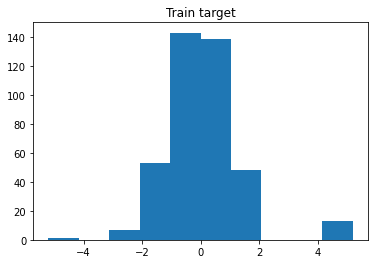

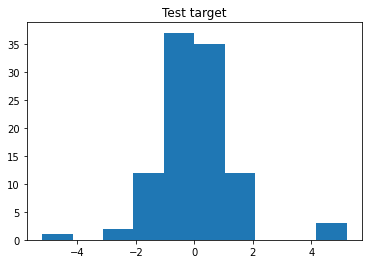

In [22]:
RANDOM_SEED = 42

seed_everything(RANDOM_SEED)

X_train, X_test, y_train, y_test = get_and_process_boston_dataset(random_state=RANDOM_SEED)

visualise_boston(X_train, X_test, y_train, y_test)

In [23]:
data = pd.read_csv('data.csv', encoding='cp1251', sep=';', decimal=',').dropna()

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:,-1], test_size=0.5)

In [26]:
for col in X_train.columns:
    for sh in range(1,7):
        X_train[f'{col}_{sh}'] = X_train.shift(sh)[col]
        X_test[f'{col}_{sh}'] = X_test.shift(sh)[col] 
for lag in range(1,7):
    X_train[f'ІСЦ_{lag}'] = y_train.shift(lag)
    X_test[f'ІСЦ_{lag}'] = y_test.shift(lag)

In [27]:
X_train = X_train.dropna()
X_test = X_test.dropna()

In [28]:
X_train

,НВВП1,ОПП,ІРПП,%ІСЦ,%ІОЦ,ДБ,М2,СР,РПСК,КНБУ,...,ОК_$_3,ОК_$_4,ОК_$_5,ОК_$_6,ІСЦ_1,ІСЦ_2,ІСЦ_3,ІСЦ_4,ІСЦ_5,ІСЦ_6
35,9180,8004,41.1,1.0,0.4,3208.2,11946,60.0,4.6,15610,...,1.90909,3.92352,1.84190,1.83708,6.2,0.1,0.2,0.1,0.1,0.8
3,7209,5393,41.9,0.1,0.6,2733.0,6454,40.0,5.4,5283,...,1.81977,1.90909,3.92352,1.84190,2.3,6.2,0.1,0.2,0.1,0.1
34,7960,6905,40.8,1.0,1.1,2608.8,11756,60.0,3.8,15372,...,2.18321,1.81977,1.90909,3.92352,5.7,2.3,6.2,0.1,0.2,0.1
23,7501,6535,42.6,0.2,0.7,3115.3,10973,42.6,3.9,7755,...,3.65771,2.18321,1.81977,1.90909,1.0,5.7,2.3,6.2,0.1,0.2
31,9905,7387,38.4,3.0,3.5,3311.5,11366,82.0,2.2,14230,...,1.78084,3.65771,2.18321,1.81977,1.3,1.0,5.7,2.3,6.2,0.1
10,6107,5076,42.0,1.2,0.4,2047.4,7599,35.0,4.0,5734,...,3.47086,1.78084,3.65771,2.18321,3.3,1.3,1.0,5.7,2.3,6.2
22,6511,5466,42.4,0.2,0.9,2267.1,10166,42.4,3.9,7479,...,2.03402,3.47086,1.78084,3.65771,0.1,3.3,1.3,1.0,5.7,2.3
18,8847,6581,41.7,0.9,1.1,3458.4,10123,16.0,2.3,6199,...,3.42722,2.03402,3.47086,1.78084,0.2,0.1,3.3,1.3,1.0,5.7
20,10683,5860,41.7,1.4,0.5,4636.9,10775,35.0,2.1,7142,...,1.84364,3.42722,2.03402,3.47086,0.9,0.2,0.1,3.3,1.3,1.0
7,7529,5652,42.4,1.2,1.2,2853.6,6443,40.0,4.3,5927,...,1.95656,1.84364,3.42722,2.03402,1.3,0.9,0.2,0.1,3.3,1.3


# GMDH Hypersearh

## Possible architectures

If we have one GMDH layer - GMDH -> Dense

If we have two or more GMDH layers - ( GMDH -> Dense (F - outputs) ) * (N_GMDH_layers-1) -> GMDH -> Dense

In [29]:
model = GMDH(
        input_shape=X_train.shape[0], 
        method_type='fuzzy', 
        poli_type='partial_quadratic',
        loss=MSE, 
        confidence=0.9,
        reg_coef=0.01
    )

In [30]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [31]:
def gmdh_pipeline_predict(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs: tp.Dict[tp.Tuple[int], np.ndarray],
                  model_weights: np.ndarray) -> np.ndarray:
    outputs = []
    for i, (k, model) in enumerate(models.items()):
        predicted = model_weights[i] * model.predict(inputs[k]).ravel()
        outputs.append(predicted)
    outputs = np.array(outputs).T
    return np.sum(outputs, axis=1)[..., np.newaxis]

def gmdh_pipeline_fit(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs_train: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_train: np.ndarray,
                  inputs_val: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_val: np.ndarray) -> np.ndarray:
    outputs_partial_train = []
    outputs_partial_test = []
    for k, model in models.items():
        predicted_train = model.predict(inputs_train[k]).ravel()
        outputs_partial_train.append(predicted_train)
        predicted_test = model.predict(inputs_val[k]).ravel()
        outputs_partial_test.append(predicted_test)
    outputs_partial_train = np.array(outputs_partial_train).T
    outputs_partial_test = np.array(outputs_partial_test).T
    W_vect = lstsq(outputs_partial_train, outputs_train.ravel())
    return W_vect[0]

In [32]:
y_train = y_train[6:][..., np.newaxis]
y_test = y_test[6:][..., np.newaxis]

In [49]:
do_hypersearh = True
n_gmdh_layers = 1
best_activations = 16
all_metrics = []
best_model = None
best_history = None

all_possible_pairs = list(combinations(range(X_train.shape[1]),2))[::-2][:100]
possible_models = dict()
possible_pairs_train = dict()
possible_pairs_test = dict()
best_W = None

i = 0
while do_hypersearh:
    partial_model = GMDH(
                        input_shape=len(all_possible_pairs[i]), 
                        method_type='fuzzy', 
                        poli_type='partial_quadratic',
                        loss=FMSE, 
                        confidence=0.9,
                        reg_coef=0.01
                    )
    print(f"Partial model structure: {partial_model.__dict__}")
    
    trained, history = partial_model.fit(
        train_sample=(X_train[:, all_possible_pairs[i]], y_train),
        validation_sample=(X_test[:, all_possible_pairs[i]], y_test),
        optimiser=SimplexOptimizer(alpha=0.01, eta=0.005),
        batch_size=16,
        epochs=1000,
        verbose=False
    )
    possible_models.update({all_possible_pairs[i]: trained})
    possible_pairs_train.update({all_possible_pairs[i]: X_train[:, all_possible_pairs[i]]})
    possible_pairs_test.update({all_possible_pairs[i]: X_test[:, all_possible_pairs[i]]})
    
    if (n_gmdh_layers == 1):
        prediction = trained.predict(X_test[:, all_possible_pairs[i]])
        test_metric = MSE(y_test, prediction)[0]
        all_metrics.append(test_metric)
        W_vect = np.array([1.])
    else:
        W_vect = gmdh_pipeline_fit(possible_models, possible_pairs_train, y_train, possible_pairs_test, y_test)
        prediction = gmdh_pipeline_predict(possible_models, possible_pairs_test, W_vect)
        test_metric = MSE(y_test, prediction)[0]
        all_metrics.append(test_metric)
    i += 1
    print(f"{n_gmdh_layers} layers scored {test_metric}")
    
    if (len(all_metrics) == 1 or (all_metrics[-1] < all_metrics[-2]+0.01)) and (i<len(all_possible_pairs)):
        do_hypersearh = True
    else:
        do_hypersearh = False
        best_W = W_vect
        
    n_gmdh_layers += 1

Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x0000023D21BE25B0>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.9, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x0000023D21BE2310>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function FMSE at 0x0000023D214AD430>, 'W_vect': array([0.06715473, 0.08928569, 0.20026452, 0.04001149, 0.03217875,
       0.02626444, 0.08675965, 0.09970799])}



1 layers scored 1.0857867865993187
Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x0000023D7FEDC970>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.9, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x0000023D7FEDC310>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function FMSE at 0x0000023D214AD430>, 'W_vect': array([0.06715473, 0.08928569, 0.20026452, 0.04001149, 0.03217875,
       0.02626444, 0.08675965, 0.09970799])}



2 layers scored 0.8968348109842577
Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x0000023D241C06A0>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.9, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x0000023D241C0FA0>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function FMSE at 0x0000023D214AD430>, 'W_vect': array([0.06715473, 0.08928569, 0.20026452, 0.04001149, 0.03217875,
       0.02626444, 0.08675965, 0.09970799])}


<ipython-input-31-8d1e0d1a6a6a>:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W_vect = lstsq(outputs_partial_train, outputs_train.ravel())



3 layers scored 0.9767700081874967


# Predict and Visualise losses

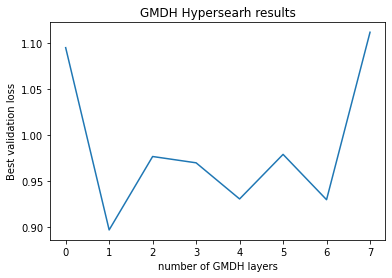

In [41]:
plt.title('GMDH Hypersearh results')
plt.plot(all_metrics)
plt.xlabel('number of GMDH layers')
plt.ylabel('Best validation loss')
plt.show()

In [46]:
prediction = gmdh_pipeline_predict(possible_models, possible_pairs_test, best_W)
prediction_train = gmdh_pipeline_predict(possible_models, possible_pairs_train, best_W)

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.27801953606916
Train MSE: 0.47181171083458373


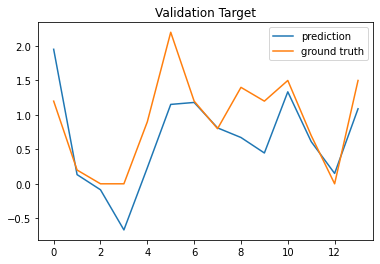

In [45]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

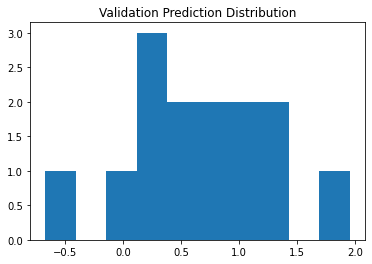

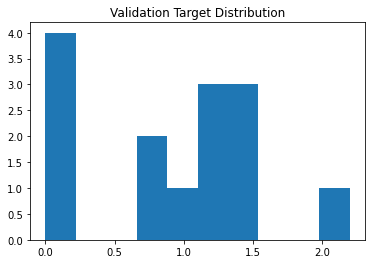

In [47]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()